# Introduction : West Nile Virus
___

**Problem Statement**

1. Given weather, location, testing, and spraying data, predict when and where different species of mosquitos will test positive for West Nile virus. 
2. Is pesticide effective : Population before 2011 vs Population After 2013.


**Key variables**

|Data|Description|
|---|---|
|Id|Id of the Mosquito|
|Species|Species of Mosquito|
|Address|Location of Trap|
|Block| Block nunber of address|
|Street| Street Name|
|Trap ID| Id of Trap. Letter behind Trap ID indicate it is near a main Trap|
|Latitude , Longtitude|Location of Trap , Mosquito|
|NumMosquito| No. of Mosquito|
|WNV_Present| 1 means WNV is present, and 0 means not present|
|Spray CSV| Latitude , Longtitude. Dataset only at 2011, 2013|

**Model Explored**

**workflow**
1. EDA
2. Feature Engineering 
3. Data Preprocessing
4. Modelling to predict WNV probability (without pesticide)
5. Select best Model to study the effect of pesticide
  * 5.1 Hypothesis : Pesticide has no effect on Mosquito population

**Key Insight**

We need to derive an effective plan to deploy pesticides throughout the city, and that is exactly where you come in!  


# 0.0 Libraries Import
___

In [1]:
# # installing less common packages (uncomment if you do not have these installed)
#!pip install geopy
!pip install geopandas
!pip install featuretools

In [2]:
# import libraries
import pandas as pd, numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits import mplot3d
import seaborn as sns

import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopy.distance import geodesic

import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier


sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline

# 1.0 Data Import
___

In [3]:
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/test.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/spray.csv

--2021-10-28 12:24:49--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797335 (1.7M) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>]   1.71M  --.-KB/s    in 0.01s   

2021-10-28 12:24:49 (136 MB/s) - ‘train.csv.2’ saved [1797335/1797335]

--2021-10-28 12:24:49--  https://raw.githubusercontent.com/86lekwenshiung/West-Nile-Virus-Prediction/main/dataset/weather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response..

In [4]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_spray = pd.read_csv('/content/spray.csv')
df_weather = pd.read_csv('/content/weather.csv')

df_train.shape,df_test.shape,df_spray.shape,df_weather.shape

((10506, 12), (116293, 11), (14835, 4), (2944, 22))

In [5]:
!wget https://raw.githubusercontent.com/zzeniale/West-Nile-Virus-prediction/master/assets/mapdata_copyright_openstreetmap_contributors.txt

--2021-10-28 12:24:50--  https://raw.githubusercontent.com/zzeniale/West-Nile-Virus-prediction/master/assets/mapdata_copyright_openstreetmap_contributors.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40907049 (39M) [text/plain]
Saving to: ‘mapdata_copyright_openstreetmap_contributors.txt.2’

mapdata_copyright_o 100%[===================>]  39.01M   200MB/s    in 0.2s    

2021-10-28 12:24:50 (200 MB/s) - ‘mapdata_copyright_openstreetmap_contributors.txt.2’ saved [40907049/40907049]



# 2.0 EDA (Basic EDA)
___

### 2.1 Effect of Spray and Distance(Julian)
___

In [6]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_spray['Date'] = pd.to_datetime(df_spray['Date'])

In [7]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [8]:
dfs = [
    (df_train, 'trap'),
    (df_spray, 'spray'),
    (df_weather, 'weather'),
    (df_test, 'test')
    ]

In [9]:
[basic_eda(df, name) for df, name in dfs]

TRAP

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object
-----

SPRAY

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object
-----

WEATHER

Rows: 2944 	 Columns: 22

Total null rows: 0
Percentage null rows: 0.0

[None, None, None, None]

# Traps
This dataframe contains information associated with each mosquito trap deployed across the city of Chicago. The location of the traps are described by the block number and street name which have been conveniently mapped into Latitude and Longitude.

In [10]:
df_train.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [11]:
print(df_train.Date.min())
print(df_train.Date.max())
df_train.head()

2007-05-29 00:00:00
2013-09-26 00:00:00


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


# Mosquito species
Although all species sampled are carriers of WNV, the presence of WNV was tested positive for Culex restuans, C. pipiens, and C.pipiens/restuans. In addition, these 3 categories made up more than 96% of the sample of the species sampled.

(https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf).

In [12]:
# what species are there
print(f'number of species: {df_train["Species"].nunique()}')
df_train["Species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64

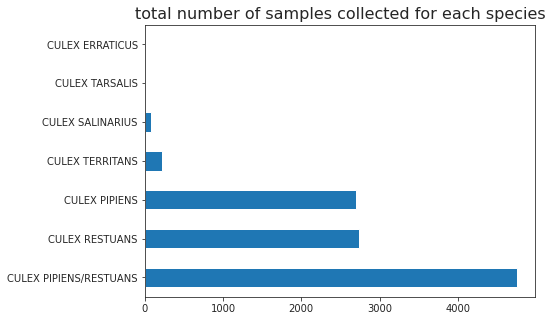

In [13]:
df_train['Species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('total number of samples collected for each species', fontsize=16);

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


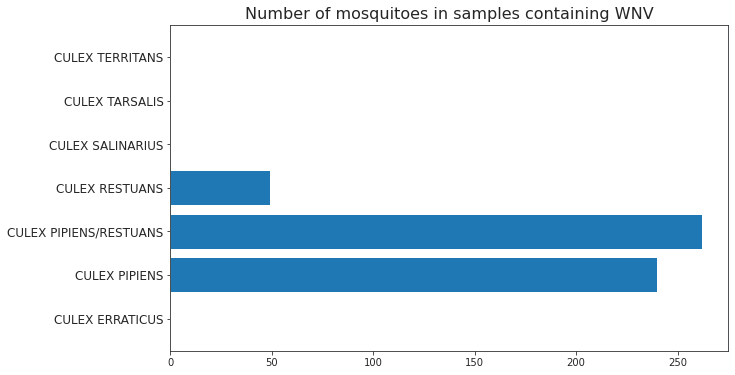

In [14]:
mos_wnv = df_train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

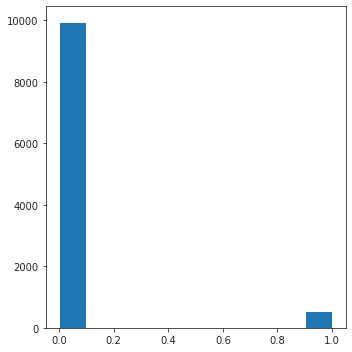

In [15]:
plt.figure(figsize=(5,5))
plt.hist(df_train.WnvPresent)
# plt.title('WNV presence by mosquito species', fontsize=16)
# plt.yticks(fontsize=12)
# plt.ylabel('')
# plt.xlabel('Total number of mosquitos',fontsize=14)
plt.tight_layout()

# Add datetime columns

In [16]:
# make datetime columns
df_train['Year'] = df_train['Date'].apply(lambda x:x.year)
df_train['Month'] = df_train['Date'].apply(lambda x:x.month)
df_train['WeekofYear'] = df_train['Date'].apply(lambda x:x.weekofyear)
df_train['YearMonth'] = df_train['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# year 2007 - 2013
print(df_train.Year.value_counts().sort_index().head(),'\n')

# data only from may - oct
print(df_train.Month.value_counts().head(),'\n')

# week 22 - 41
print(df_train.WeekofYear.value_counts().sort_index().head(),'\n')

# total number of weeks in dataset
print('total number of weeks in dataset:',df_train.WeekofYear.nunique())

2007    3811
2009    2249
2011    2054
2013    2392
Name: Year, dtype: int64 

8     3751
7     2606
9     2218
6     1571
10     276
Name: Month, dtype: int64 

22     84
23    383
24    321
25    332
26    504
Name: WeekofYear, dtype: int64 

total number of weeks in dataset: 20


# Combine mosquito counts
As the test results are organized in a way that the number of mosquitoes are capped at 50 for each record even when the samples are collected on the same day. We will combine these records into a single record.

In [17]:
df_train.shape

(10506, 16)

In [18]:
df_train = df_train.groupby([col for col in df_train.columns if col not in ['NumMosquitos']]).sum()
df_train.reset_index(inplace=True)

In [19]:
df_train.shape

(8610, 16)

# Number of traps and sampling effort

In [20]:
df_train.Trap.nunique()

136

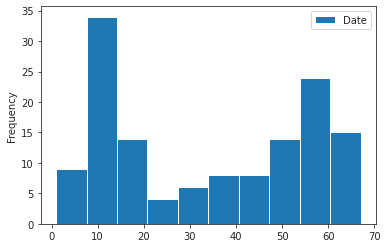

In [21]:
df_train[['Date','Trap']].groupby(['Trap']).nunique().plot(kind='hist');

There are 136 traps.
T900 (at Ohare airport) is sampled the most

In [22]:
print('Trap with the most sampling:', df_train[['Date','Trap']]\
      .groupby(['Trap']).nunique().idxmax().values[0], 'frequency',\
      df_train[['Date','Trap']].groupby(['Trap']).nunique().max().values[0])

Trap with the most sampling: T002 frequency 67


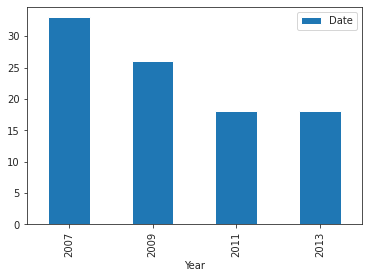

In [23]:
df_train[['Year','Date']].groupby(['Year']).nunique().plot(kind='bar');

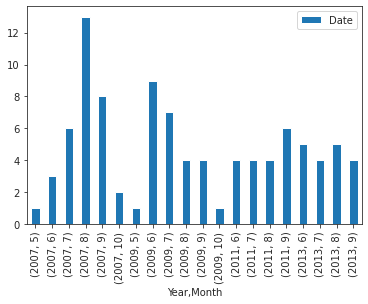

In [24]:
df_train[['Year','Month','Date']].groupby(['Year','Month']).nunique().plot(kind='bar');

Most sampling was performed in 2007 and decreased afterward. very inconsistent and high oversampling in 8-2007 leading to high pop of mosquitos in 2007

# Duplicate addresses for each trap

In [25]:
df_train[df_train.Trap=='T002']\
  .groupby(['AddressNumberAndStreet','Longitude','Latitude']).count()

,,,Date,Address,Species,Block,Street,Trap,AddressAccuracy,WnvPresent,Year,Month,WeekofYear,YearMonth,NumMosquitos
AddressNumberAndStreet,Longitude,Latitude,,,,,,,,,,,,,
"4100 N OAK PARK AVE, Chicago, IL",-87.800991,41.95469,150,150,150,150,150,150,150,150,150,150,150,150,150


In [26]:
df_train[['AddressNumberAndStreet','Trap']].groupby(['Trap']).nunique()\
    .sort_values(by='AddressNumberAndStreet',ascending=False).head(3)

,AddressNumberAndStreet
Trap,
T035,2
T009,2
T001,1



T035 is probably mislabelled for one of the addresses and T009 is probably a typo. Since coordinates are already present, trap numbers aren't important. Therefore all other location columns such as addresses and Trap will be dropped.

# Univariate EDA
## Distributions

In [27]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

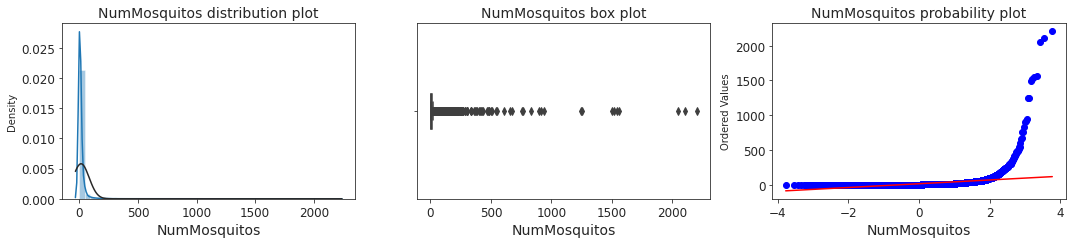

In [28]:
dist_plots(df_train, ['NumMosquitos'])

# Clustering

In [29]:
def dbscan(df, list_of_columns, eps, min_samples):
    
    df_cluster = df[list_of_columns]

    minmax = MinMaxScaler(feature_range = (0, 1))

    clusters = minmax.fit_transform(df_cluster)

    dbs = DBSCAN(eps = eps, min_samples = min_samples)
    dbs.fit(clusters)
    df['Cluster'] = dbs.labels_
    vals = df['Cluster'].value_counts()
    print(f'Silhouette Score: {silhouette_score(clusters, dbs.labels_)}')
    print(f'Number of outliers: {vals[-1]} ({vals[-1] * 100 / len(df):.2f}% of samples)')
    print(f'Number of clusters: {len(vals)}')

    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df['Latitude'], df['Longitude'], df['NumMosquitos'], c = df['Cluster'], cmap = 'rainbow')
    ax.set_title(f'DBSCAN for {list_of_columns}\n\u03B5 = {eps} Min. Clusters = {min_samples}')
    plt.show()

Silhouette Score: 0.7321141477472317
Number of outliers: 100 (2.17% of samples)
Number of clusters: 119


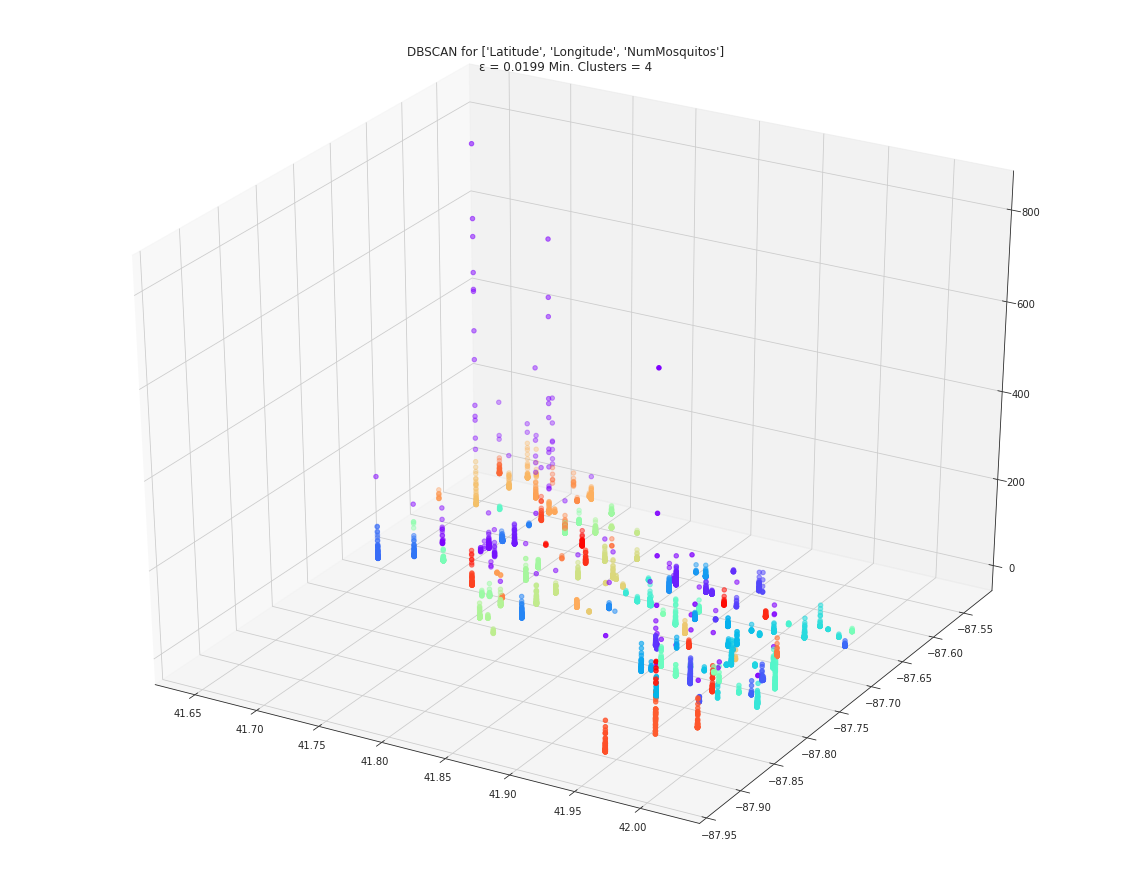

In [30]:
df_train['Coord'] = [(x, y) for x, y in zip(df_train['Latitude'], df_train['Longitude'])]

trap_cluster = df_train.groupby(['Date', 'Coord']).mean().copy()

dbscan(trap_cluster, ['Latitude', 'Longitude', 'NumMosquitos'], eps = 0.0199, min_samples = 4)

# Spray

## Handling null values and duplicates
Examine spray dataset for null values

In [31]:
spray1 = df_spray.copy()

In [32]:
spray1.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

Time data is probably too finely tuned for our needs, so we might drop Time from spray instead.

In [33]:
# looking at our dupes
spray1[spray1.duplicated(keep=False)].shape

(543, 4)

This will be assumed to be errors and will be dropped.

Spray data to drop:
- `Time` column
- duplicated rows

In [34]:
spray1.shape

(14835, 4)

In [35]:
df_spray = spray1.drop(columns='Time').drop_duplicates(keep='first')
df_spray.shape

(14294, 3)

Now, to find out

- number of unique spray dates  
- number of sprays made on each unique date

# of unique spray dates:  10 



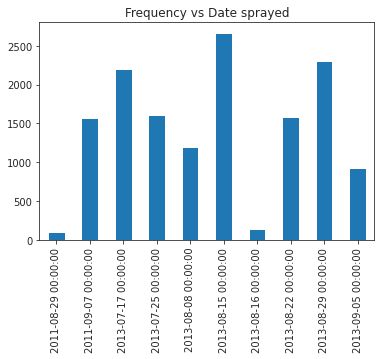

In [36]:
print('# of unique spray dates: ',df_spray["Date"].nunique(),'\n')
df_spray["Date"].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency vs Date sprayed');

Only sprayed 2 dates in 2011 and many more in 2013.

In 2013 it only starts in mid 2013-07 to start 2013-09. The pesticide may not have had strong penetration in 2011.  
Analysis for effective pesticide should start in 2014 and ignore effects in 2011

# Mosquito Population

# Tracking nearest spray location for each trap record

In [37]:
# Create full list of trap locations
trap_loc = pd.concat([df_train[['Latitude','Longitude']],\
                  df_test[['Latitude','Longitude']]],axis=0).drop_duplicates()

# Set destinations of spray
df_spray['geom'] = [Point(x,y) for x,y in \
                    zip(df_spray.Latitude,df_spray.Longitude)]
destinations = MultiPoint(df_spray['geom'].tolist())

dist = []
for x,y in zip(trap_loc.Latitude, trap_loc.Longitude):
  # set location of trap
  orig = Point(x,y)

  # get distance
  # find nearest points
  nearest_geoms = nearest_points(orig, destinations)
  # measure trap to nearest spray
  a, b = (x, y) ,(nearest_geoms[1].x,nearest_geoms[1].y)
  dist.append(geodesic(a,b).m)



# add distance to trap locations
trap_loc['dist_spray'] = dist

In [38]:
# merge dist and train, test
df_train = df_train.merge(trap_loc,on=['Latitude','Longitude'])
df_test  = df_test.merge(trap_loc,on=['Latitude','Longitude'])

In [39]:
df_train['sprayed'] = df_train['dist_spray'].apply(lambda x: 0 if x > 500 else 1)

In [40]:
df_train.to_csv('df_train_dist.csv',index=False)

## Total mosquito count by Year-Month (species combined)

Year  Month
2007  5           40
      6          428
      7         7199
      8        40015
      9         9300
      10        1706
2009  5          190
      6         7390
      7         8833
      8         2346
      9         2137
      10         212
2011  6         4049
      7         8445
      8         2968
      9         3337
2013  6         4711
      7        12771
      8        12707
      9         6255
Name: NumMosquitos, dtype: int64

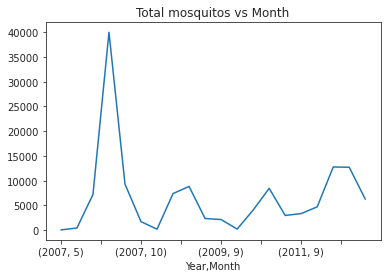

In [41]:
df_train.groupby(['Year','Month'])['NumMosquitos'].sum().plot()
plt.title('Total mosquitos vs Month')
df_train.groupby(['Year','Month'])['NumMosquitos'].sum()

> peaks in mosquitos vary each year between Aug or Sep

## Total mosquito count by Year-Month (by species)

Text(0.5, 1.0, 'Total Mosquito species vs Month')

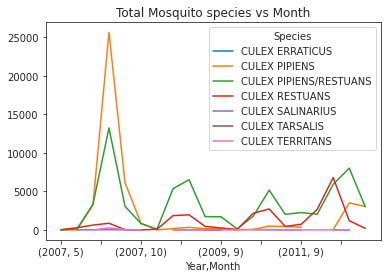

In [42]:
df_train.groupby(['Year','Month','Species'])['NumMosquitos'].sum().unstack().plot()
plt.title('Total Mosquito species vs Month')
# df_train.groupby(['Year','Month','Species'])['NumMosquitos'].sum().unstack().fillna(0)

> 2007 peak in Pipiens has been switched with Restuans. Pipiens/Restuans may reference either Pipiens or Restuans

# Total mosquito count by day in the year (by species)

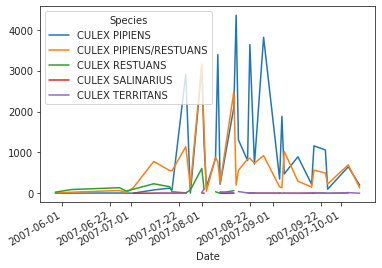

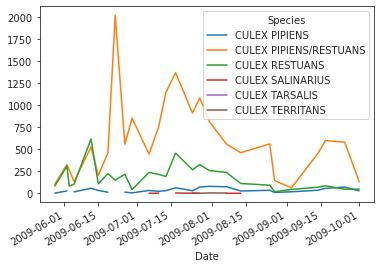

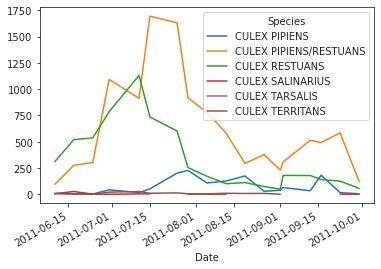

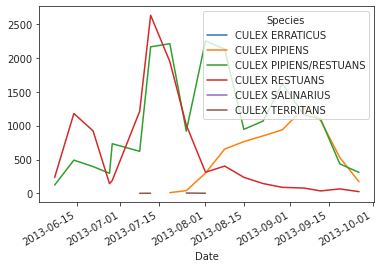

In [43]:
for year in df_train.Year.unique():
  df_train.loc[df_train.Year == year].groupby(['Date','Species'])['NumMosquitos'].sum().unstack().plot();

> there is a strong presence of pipiens in 2007 that tapers down. 2013 has a very mixed population

# Total mosquito count by day (by species)

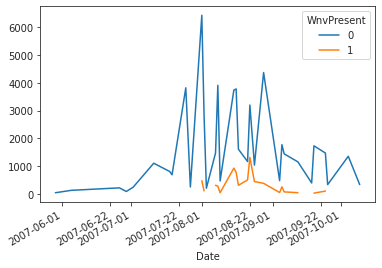

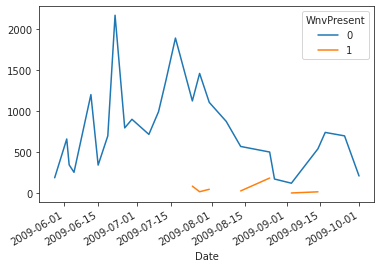

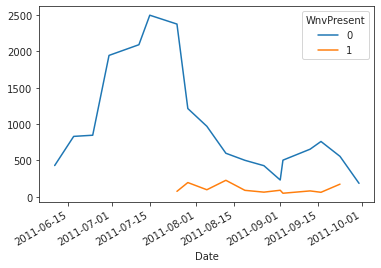

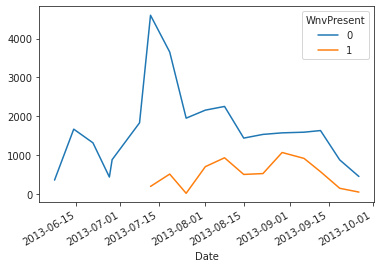

In [44]:
for year in df_train.Year.unique():
  df_train.loc[df_train.Year == year].groupby(['Date','WnvPresent'])['NumMosquitos'].sum().unstack().plot();

> start of WNV appearance seems to coincide with the decrease in population of the PIPIENS/RESTUANS population

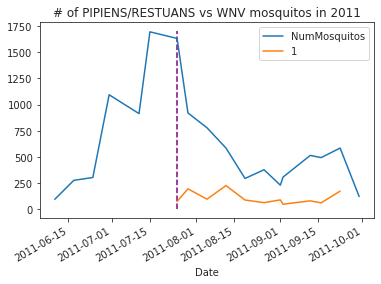

In [45]:
#plotting number of PIPIENS/RESTUANS population and # of WNV  mosquitos in 2011

a = df_train.loc[(df_train.Year == 2011)&(df_train.Species=='CULEX PIPIENS/RESTUANS')].groupby(['Date'])['NumMosquitos'].sum()
b = df_train.loc[df_train.Year == 2011].groupby(['Date','WnvPresent'])['NumMosquitos'].sum().unstack().drop(columns=0)

pd.concat([a,b],axis=1).plot()
plt.vlines('2011-07-25',0,1700, linestyles='dashed', color='purple')
plt.title('# of PIPIENS/RESTUANS vs WNV mosquitos in 2011');

# Weather
The weather records provided are between 2007 May and 2014 October. There is a second record everyday as there are 2 weather stations capturing the data each day. From the weather dataset, we are going to focus on variables translating to the optimal condition in the environment for reproduction and they are mainly separated into 2 sections; their habitats and temperature.

Habitat:

Culex mosquitoes breed in various types of stagnant water. Preferred oviposition habitats such as rainwater barrels, catch basins, storm drains, and septic tanks are rich in organic material. Eggs are laid in raft-shaped batches on the water surface.

While Culex will lay their eggs in a variety of standing waters, these habitats can typically be categorized into four ecotypes:

Sewage Systems
Container Sources
Drainage Systems
Open Habitats
https://www.valentbiosciences.com/publichealth/pests/mosquitoes/mosquitoes-culex/

Temperature:

According to a study conducted on the effects of temperature on the growth and development of Culex pipiens Complex Mosquitoes, it was discovered that varying temperatures were found to have effects on egg embryonation, the lengths of the pupal and larval periods and the survival and longevity of the female mosquitoes.

In lower temperatures, embryonation took longer among the 20 degree Celsius (68 degree Fahrenheit) and 24 degree Celsius (75.2 degree Fahrenheit) the larval and pupal stages were longer and the female mosquitoes lived longer.
In higher temperatures, 28 degree Celsius (84.4 degree Fahrenheit), embryonation was faster, the larval and pupal stages were shorter and the females did not live for as long as they did at 20 degree Celsius and 24 degree Celsius.
https://pdfs.semanticscholar.org/1e02/57f23ef925e437a5995c1720b3a2ab518cac.pdf

As such, at first glance, it it likely that the columns "Tmax", "Tmin" and "Tavg", "PrecipTotal", "DewPoint", "AvgSpeed" can be relevant.



In [46]:
df_weather.head(4).T

,0,1,2,3
Station,1,2,1,2
Date,2007-05-01,2007-05-01,2007-05-02,2007-05-02
Tmax,83,84,59,60
Tmin,50,52,42,43
Tavg,67,68,51,52
Depart,14,M,-3,M
DewPoint,51,51,42,42
WetBulb,56,57,47,47
Heat,0,0,14,13
Cool,2,3,0,0


## Weather Data Wrangling

In [47]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [48]:
## Create date cols
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['Year'] = df_weather['Date'].apply(lambda x:x.year)
df_weather['Month'] = df_weather['Date'].apply(lambda x:x.month)
df_weather['WeekofYear'] = df_weather['Date'].apply(lambda x:x.weekofyear)

# view summary of unique values
print(df_weather.Year.value_counts().sort_index().head())
print(df_weather.Month.value_counts().head())
print(df_weather.WeekofYear.value_counts().sort_index().head())

2007    368
2008    368
2009    368
2010    368
2011    368
Name: Year, dtype: int64
5     496
7     496
8     496
10    496
6     480
Name: Month, dtype: int64
17      6
18     84
19    112
20    112
21    112
Name: WeekofYear, dtype: int64


In [49]:
## fill missing values
# there is missing values of '  T','M'
df_weather.PrecipTotal.value_counts().sort_index()

  T      318
0.00    1577
0.01     127
0.02      63
0.03      46
        ... 
3.97       1
4.73       1
6.64       1
6.86       1
M          2
Name: PrecipTotal, Length: 168, dtype: int64

In [50]:
# There is missing values here but will impute as ave of max and min
df_weather.Tavg.value_counts(normalize=True).sort_index().tail()

91    0.001359
92    0.000340
93    0.000340
94    0.000340
M     0.003736
Name: Tavg, dtype: float64

In [51]:
# will impute as mean of col because it is also a small %
df_weather.AvgSpeed.value_counts(normalize=True).sort_index()

1.7     0.000340
1.9     0.000340
10.0    0.008832
10.1    0.012568
10.2    0.005435
          ...   
9.6     0.011549
9.7     0.008832
9.8     0.008152
9.9     0.010870
M       0.001019
Name: AvgSpeed, Length: 178, dtype: float64

In [52]:
# replace error terms with 0 precip
df_weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
df_weather.PrecipTotal = df_weather.PrecipTotal.astype(float)

# imputing Tavg manually (increases accuracy)
df_weather.Tavg = df_weather.apply(lambda row:\
                      (row.Tmax + row.Tmin)/2 if row.Tavg=='M' \
                          else row.Tavg,axis=1)
df_weather.Tavg = df_weather.Tavg.astype(float)



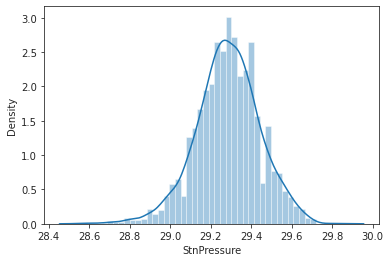

In [53]:
sns.distplot(df_weather.loc[(df_weather.StnPressure != 'M'), 'StnPressure'].map(lambda x : float(x)))

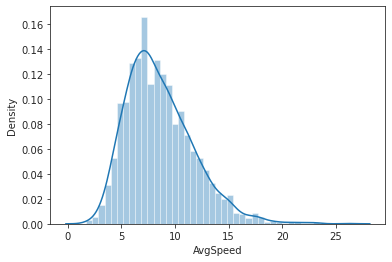

In [54]:
sns.distplot(df_weather.loc[(df_weather.AvgSpeed != 'M'), 'AvgSpeed'].map(lambda x : float(x)))

In [55]:
# impute avg speed and pressure
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')

df_weather.StnPressure = df_weather.StnPressure.map(lambda x : np.nan if x == 'M' else x)
df_weather.AvgSpeed = df_weather.AvgSpeed.map(lambda x : np.nan if x == 'M' else x)

df_weather.StnPressure = imp_mean.fit_transform(df_weather.StnPressure.values.reshape(-1, 1))
df_weather.AvgSpeed = imp_mean.fit_transform(df_weather.AvgSpeed.values.reshape(-1, 1))

# Extra features?

#Weather EDA

## Differences in weather stations

Since there are 2 weather stations capturing the weather statistics each day, we will explore the differences in the data captured for each station, mainly focusing on the columns "Tavg" and "PrecipTotal" which are likely to provide more information on our target.

In [56]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month', 'WeekofYear'],
      dtype='object')

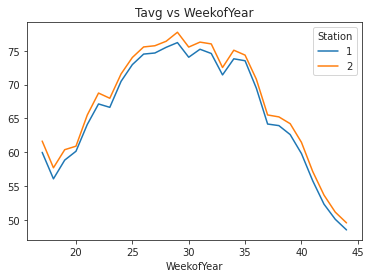

In [57]:
df_weather.groupby(['WeekofYear','Station']).Tavg.mean().unstack().plot()
plt.title('Tavg vs WeekofYear');

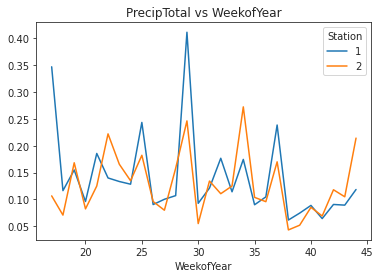

In [58]:
df_weather.groupby(['WeekofYear','Station']).PrecipTotal.mean().unstack().plot()
plt.title('PrecipTotal vs WeekofYear');

the discrepancies between the 2 weather stations seem to be insignificant visually especially from the graph showing the average temperature.

### Distribution plots

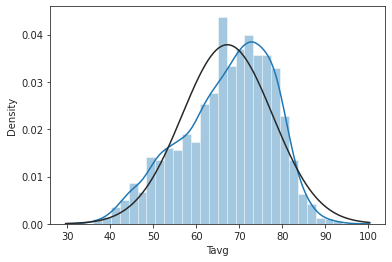

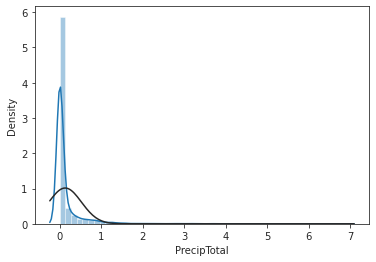

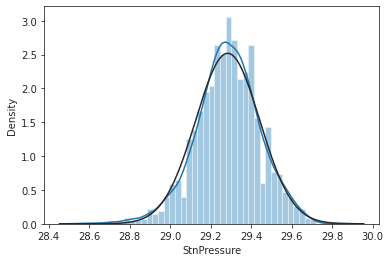

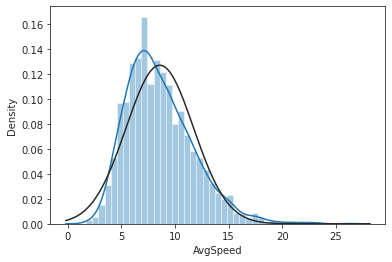

In [59]:
# Extra
for col in ['Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed']:
  sns.distplot(df_weather[col],fit=stats.norm)
  plt.show()

### Features over time

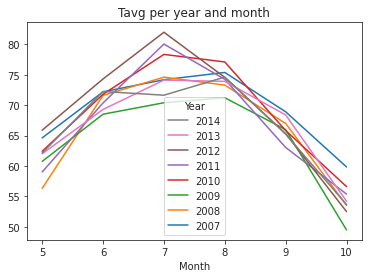

In [60]:
df_weather.groupby(['Month','Year']).Tavg.mean().unstack().plot(legend='reverse')
plt.title('Tavg per year and month');

Temperatures are getting warm then cool to the end of the month again

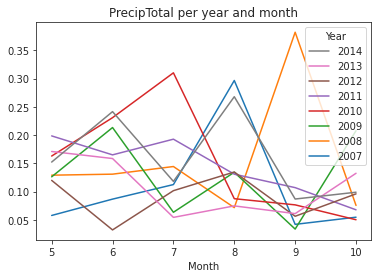

In [61]:
df_weather.groupby(['Month','Year']).PrecipTotal.mean().unstack().plot(legend='reverse')
plt.title('PrecipTotal per year and month');

non distinctive. There is a peak on 8-2007 where capture of mosquitos is high

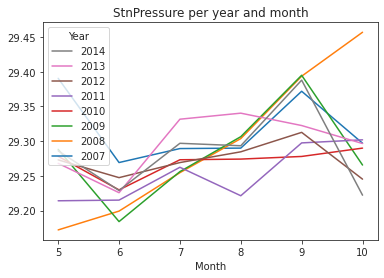

In [62]:
df_weather.groupby(['Month','Year']).StnPressure.mean().unstack().plot(legend='reverse')
plt.title('StnPressure per year and month');

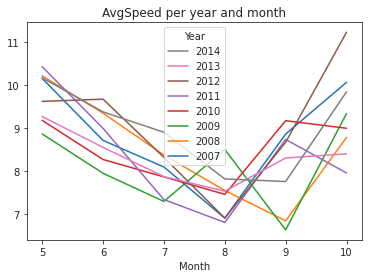

In [63]:
df_weather.groupby(['Month','Year']).AvgSpeed.mean().unstack().plot(legend='reverse')
plt.title('AvgSpeed per year and month');

Trend of speed down to up in aug where growth of WNV is high

# Merge Datasets

In [64]:
station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
df_train['nearest_station'] = df_train.apply(lambda row :
                                  1 if nearest_points(station_points, Point(row.Coord))[0] == station_points[0] else 2, axis=1)


In [65]:
df = pd.merge(df_train,df_weather.drop(columns=['Year','Month','WeekofYear'])
        ,how='left',left_on=['Date','nearest_station'],right_on=['Date','Station'])

In [66]:
df.shape

(8610, 41)

## Pairplot

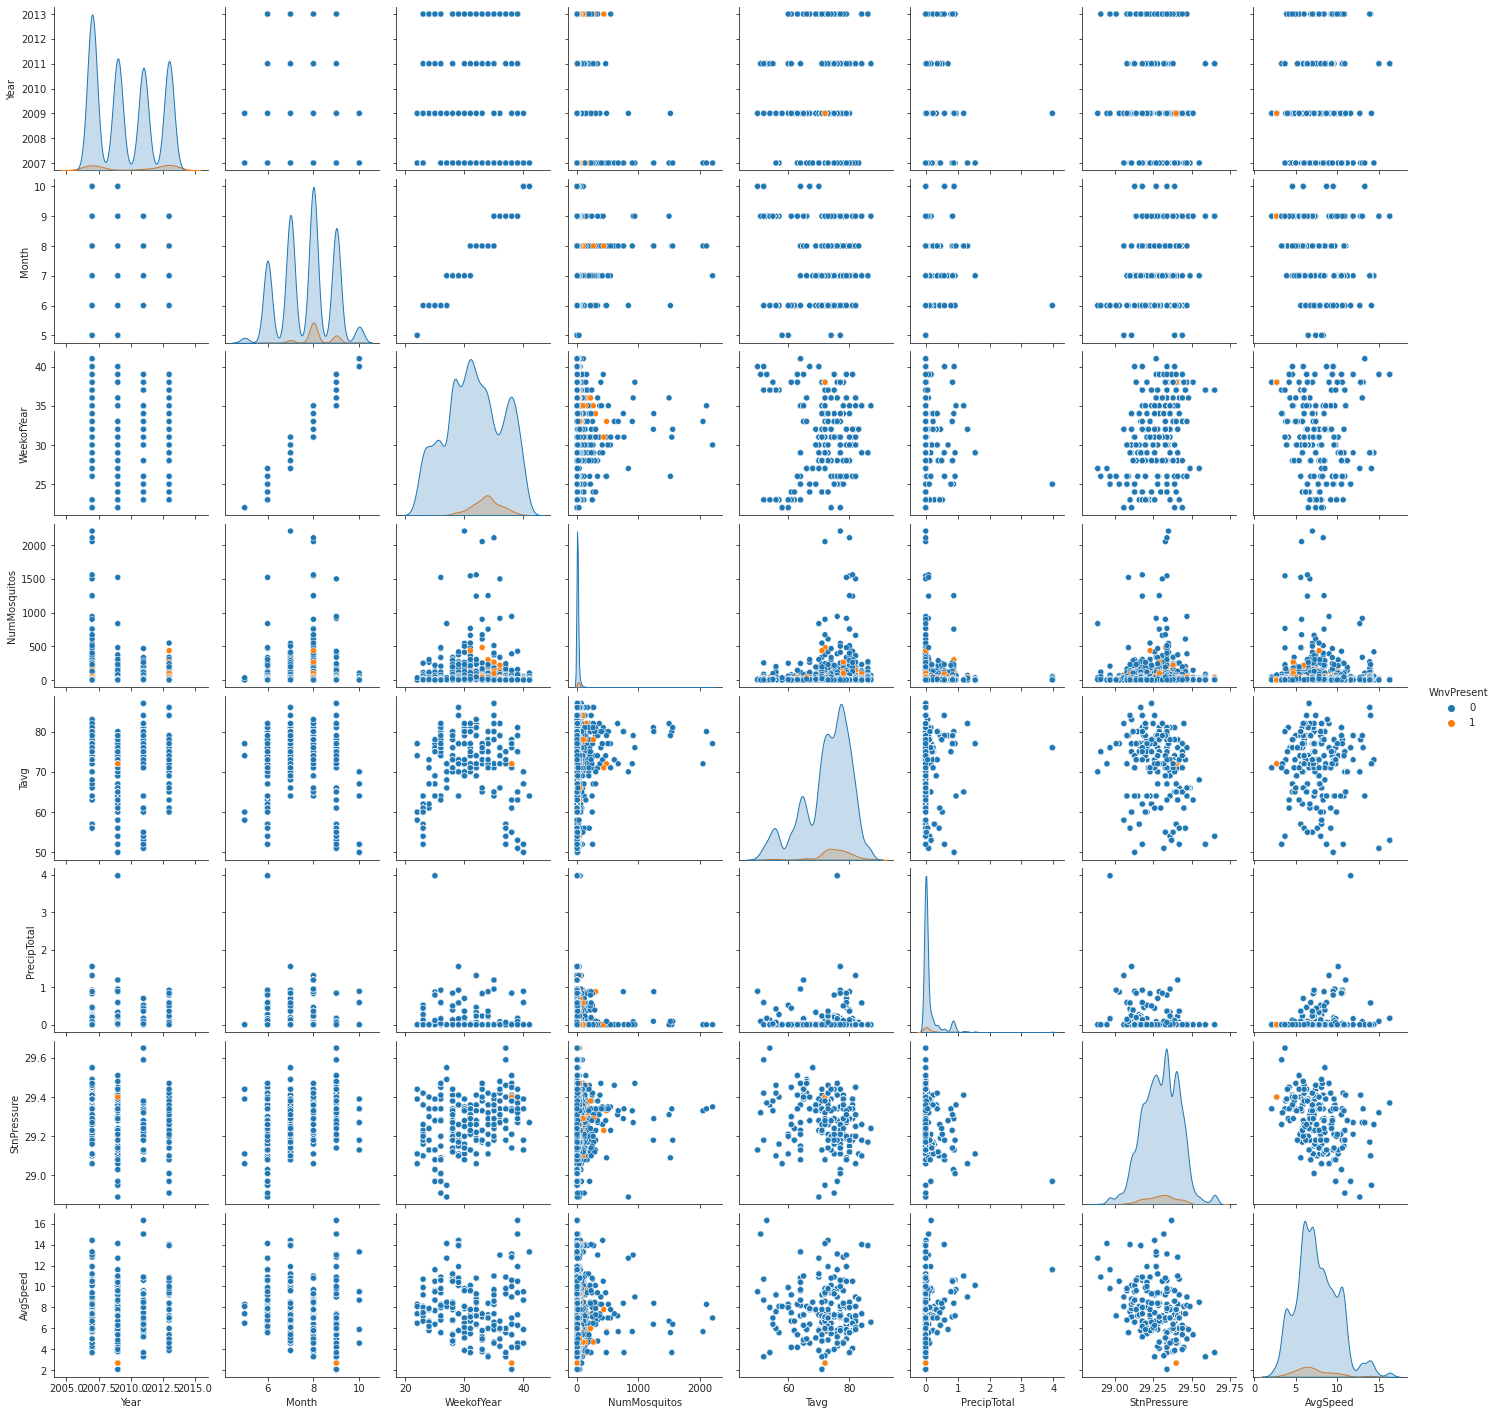

In [67]:
sns.pairplot(df[['WnvPresent','Year','Month','WeekofYear','NumMosquitos','Tavg',\
                       'PrecipTotal','StnPressure','AvgSpeed']],hue='WnvPresent');

## Correlation Heatmap

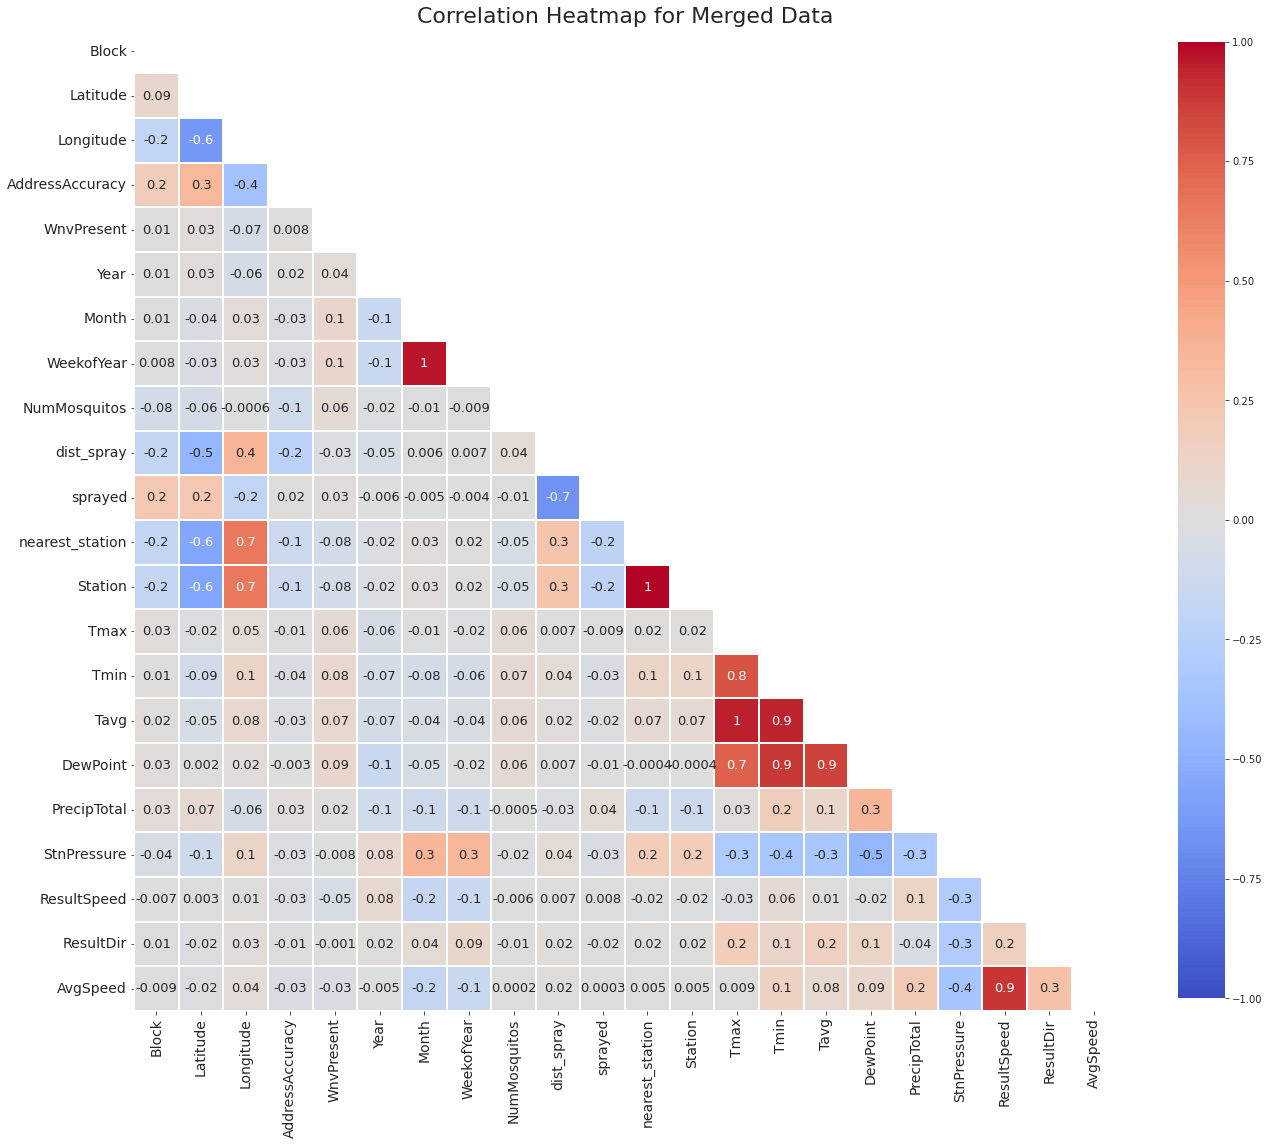

In [70]:
def heatmap(df):
    fix, ax = plt.subplots(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    ax.set_title('Correlation Heatmap for Merged Data', fontsize=22);

heatmap(df)

From the pairplot and heatmap, there are no obvious correlation.Probably due to the nature of an imbalance dataset.

# Map

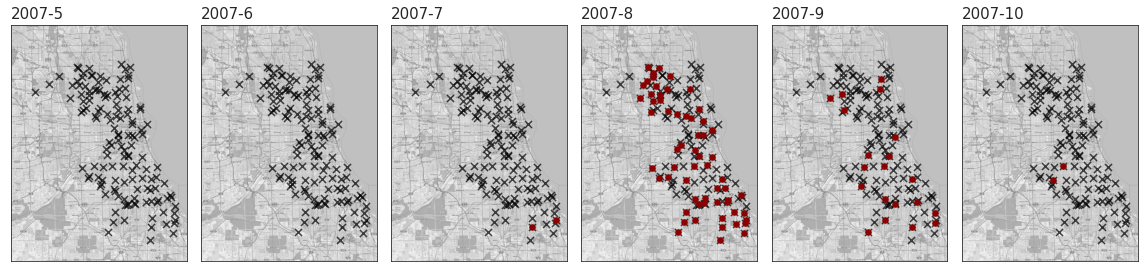

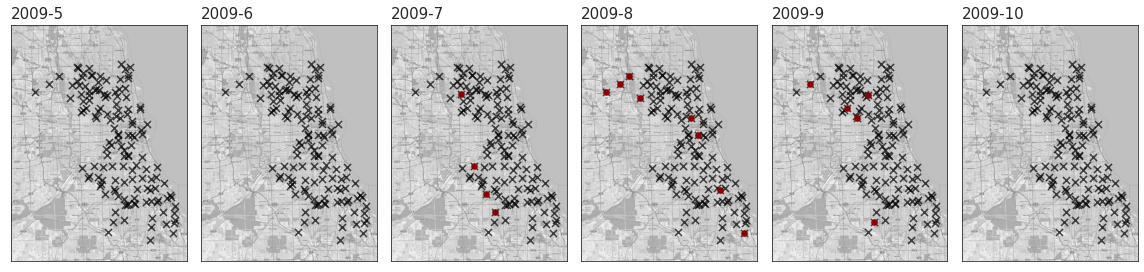

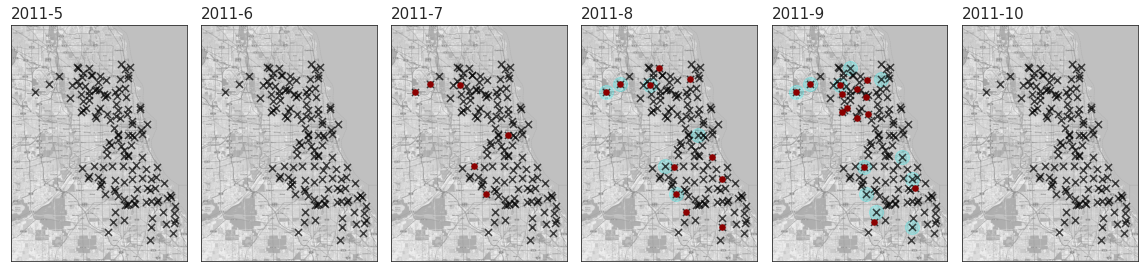

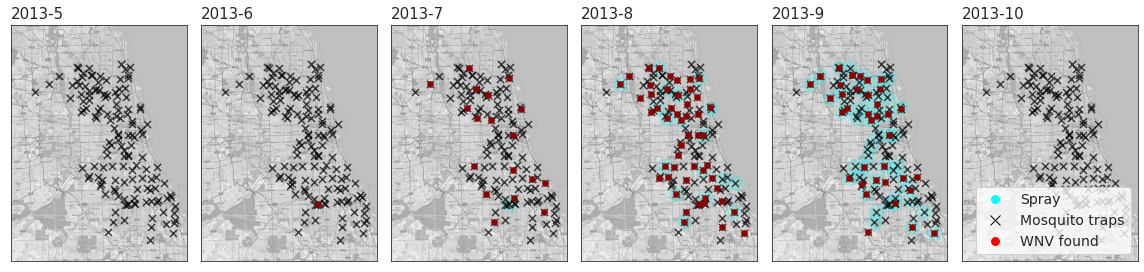

In [69]:
# plot spray data
df_spray['year'] = df_spray.Date.apply(lambda x:x.year)
df_spray['month'] = df_spray.Date.apply(lambda x:x.month)

# set up basemap
mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt')
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
for year in df.Year.unique():
    fig, ax = plt.subplots(ncols = 6, figsize = (16,5))
    
    for i, month in enumerate([5,6,7,8,9,10]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # plot spray locations for year and month
        if year in df_spray.year.unique() and month in df_spray.month.unique():
            sprayed = df_spray[(df_spray.year == year) & (df_spray.month == month)][['Longitude', 'Latitude']].drop_duplicates().values
            ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'cyan', s = 200, alpha = 0.2)
        
        # plot trap locations
        locations = df[['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations for year and month
        wnv = df[(df.Year == year) & (df.Month == month) & (df.WnvPresent == 1)]\
                [['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'darkred', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='o', color='w',label='Spray', markerfacecolor='cyan', markersize=10),
                 Line2D([0],[0],marker='x', color='black', label='Mosquito traps',linestyle='', markersize=10),
                 Line2D([0],[0],marker='o', color='w',label='WNV found',markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.tight_layout()

From the map above, it is clear that the presence of WNV almost always increase from July and peak in the month of August where the temperature is 68 to 75 degrees Fahrenheit. From our research, mosquitoes seem to breed faster but also die faster at a higher temperature. Although, we do not have the upper and lower limit of the temperature where it stops affecting the life cycle of mosquitoes, there isn't much discrepancy in the temperature year over year.

To our surprise, wind speed does seem to affect the number of WNV present with the exception of August 2009, the mean monthly wind speed are usually low in August.

In [81]:
df[['WnvPresent','NumMosquitos']].groupby('WnvPresent').sum()/df['NumMosquitos'].sum()

,NumMosquitos
WnvPresent,
0,0.892483
1,0.107517


There is data imbalance with a high proportion of no West Nile Virus. Baseline score can be considered to be 89.2% from these results.